In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import time
from scipy.stats import skew, kurtosis
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F 
from torch_geometric.nn import TopKPooling, global_mean_pool, ChebConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader
import torch.backends.cudnn as cudnn
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

device = 'cuda:0'

In [2]:
# class EEGDataset(InMemoryDataset):
#     def __init__(self, root, eeg, tasks, transform=None, pre_transform=None):
#         self.eeg = eeg
#         self.y = tasks
#         super(EEGDataset, self).__init__(root, transform, pre_transform)
#         self.data, self.slices = torch.load(self.processed_paths[0])
        
#     @property
#     def raw_file_names(self):
#         return []
    
#     @property
#     def processed_file_names(self):
#         return ['data.pt']
    
#     def download(self):
#         pass
    
#     def process(self):
        
#         data_list = []
        
#         for sample_ind in range(self.eeg.shape[0]):
#             sample = self.eeg[sample_ind]
#             task = self.y[sample_ind]
#             feature_matrix, adjacency_matrix = getFeaturesAdjacency(sample)
#             # get edge index
#             valid_edges = np.where(adjacency_matrix > 0)
#             edge_index = np.vstack((valid_edges[0], valid_edges[1]))
#             # get edge attributes
#             nonzero_ind = np.where(adjacency_matrix.ravel())[0]
#             edge_attr = adjacency_matrix.ravel()[nonzero_ind][..., np.newaxis]
            
#             data = Data(x=torch.FloatTensor(feature_matrix),
#                         edge_index=torch.tensor(edge_index, dtype=torch.long),
#                         edge_attr=torch.FloatTensor(edge_attr),
#                         y=torch.tensor(task-1, dtype=torch.long))
#             data_list.append(data)
        
#         self.data, self.slices = self.collate(data_list)
#         torch.save((self.data, self.slices), self.processed_paths[0])

In [3]:
class EEGDataset(InMemoryDataset):
    def __init__(self, root, eeg=None, tasks=None, transform=None, pre_transform=None):
        self.eeg = eeg
        self.y = tasks
        super(EEGDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        return []
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        for i in range(len(self.eeg.edge_index)):
            data = Data(x=torch.FloatTensor(self.eeg.feature_matrix[i]),
                    edge_index=torch.tensor(self.eeg.edge_index[i], dtype=torch.long),
                    edge_attr=torch.FloatTensor(self.eeg.edge_attr[i]),
                    y=torch.tensor(self.y[i]-1, dtype=torch.long))    # save tasks
            data_list.append(data)
        
        self.data, self.slices = self.collate(data_list)
        torch.save((self.data, self.slices), self.processed_paths[0])

In [4]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.conv1 = ChebConv(tr_dataset.num_features, 32, K=3)
        self.conv2 = ChebConv(32, 64, K=4)
        self.conv3 = ChebConv(64, 128, K=5)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(128)

        # Output layer
        self.dense = Linear(128*2, tr_dataset.num_classes)

    def forward(self, x, edge_index, batch_index, edge_weight):

        # Conv layers
        hidden = self.conv1(x, edge_index, edge_weight)
        hidden = self.bn1(hidden)
        hidden = F.relu(hidden)
        
        hidden = self.conv2(hidden, edge_index, edge_weight)
        hidden = self.bn2(hidden)
        hidden = F.relu(hidden)
        
        hidden = self.conv3(hidden, edge_index, edge_weight)
        hidden = self.bn3(hidden)
        hidden = F.relu(hidden)
        
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        
        # Apply a final (linear) classifier.
        hidden = self.dense(hidden)

        return F.log_softmax(hidden, dim=1)

In [5]:
def train():
    model.train()
    running_loss = 0
    accuracy = 0
    for batch in trainloader:
        # Use GPU
        batch.cuda() 
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.flatten()) 
        # Calculating the loss and gradients
        loss = criterion(pred, batch.y)
        loss.backward()
        running_loss += loss.item()
        # Update using the gradients
        optimizer.step()
        accuracy += (torch.argmax(pred, dim=1) == batch.y).float().mean()
    return running_loss/len(trainloader), accuracy/len(trainloader)

In [6]:
def test(epoch, testloader=None):
    global best_acc, best_epoch, epochs_no_improve, patience,\
           early_stop, test_losses, batch_size, bestModel
    model.eval()
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        for batch in testloader:
            # Use GPU
            batch.cuda()
            
            pred = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.flatten())
            loss = criterion(pred, batch.y)
            test_loss += loss.item()          
            accuracy += (torch.argmax(pred, dim=1) == batch.y).float().mean()

    clean_acc = 100.*accuracy/len(testloader)
    if epoch == 1:
        best_acc = clean_acc
    if (clean_acc > best_acc):
        print('Saving..')
        torch.save(model.state_dict(), bestModel)
        epochs_no_improve = 0
        best_acc = clean_acc
        best_epoch = epoch
    else:
        epochs_no_improve += 1
    
    if epoch > 5 and epochs_no_improve == patience:
        print('Early stopping!')
        early_stop = True

    return test_loss/len(testloader), accuracy/len(testloader)

In [7]:
savePath = '/scratch/qh503/deepLearningProject/data_GCN/timeFreq25_tr1800val360ts_norm/'
bestModel = './models/baseline_tr1800-val360ts_normExtractNorm.pth'

## Extract features for each sample

In [8]:
%%time
tr_dataset = EEGDataset(root=os.path.join(savePath, 'train'))
val_dataset = EEGDataset(root=os.path.join(savePath, 'valid'))
ts_dataset = EEGDataset(root=os.path.join(savePath, 'test'))
tr_dataset

CPU times: user 22.8 ms, sys: 158 ms, total: 181 ms
Wall time: 446 ms


EEGDataset(1800)

In [9]:
# Wrap data in a data loader
batch_size = 32
num_workers = 2
trainloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
testloader = DataLoader(ts_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [10]:
model = GCN().cuda()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
cudnn.benchmark = True

GCN(
  (conv1): ChebConv(25, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 64, K=4, normalization=sym)
  (conv3): ChebConv(64, 128, K=5, normalization=sym)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense): Linear(in_features=256, out_features=4, bias=True)
)
Number of parameters:  53252


In [11]:
lr = 4e-4
# early stopping variables
epochs_no_improve = 0
patience = 80
early_stop = False
best_acc = 0
best_epoch = 0

# cross entropy
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = MultiStepLR(optimizer, milestones=[80], gamma=0.1)

In [12]:
%%time
print("Starting training...")
epochs = 301
train_losses, train_accs = [], []
valid_losses, valid_accs = [], []
for epoch in range(1, epochs):
    start = time.time()
    train_loss, train_acc = train()
    valid_loss, valid_acc = test(epoch, validloader)
    if epoch % 10 == 0:
        print('\nepoch#: {} | train loss: {:.3f} | val loss: {:.3f} | train acc: {:.3f} | val acc: {:.3f}'\
              .format(epoch, train_loss, valid_loss, train_acc*100, valid_acc*100))
        print('Best Acc: {:.3f} | Best Epoch: {} | epochs_no_improve: {}'\
              .format(best_acc, best_epoch, epochs_no_improve))
        print(f"Device = {device}; Time per iter: {(time.time() - start):.3f} seconds")
    
    if early_stop:
        print('Stopped')
        break
    scheduler.step(epoch)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

Starting training...
Saving..
Saving..
Saving..
Saving..
Saving..

epoch#: 10 | train loss: 1.044 | val loss: 1.147 | train acc: 58.114 | val acc: 51.302
Best Acc: 51.302 | Best Epoch: 10 | epochs_no_improve: 0
Device = cuda:0; Time per iter: 1.513 seconds
Saving..
Saving..
Saving..

epoch#: 20 | train loss: 0.792 | val loss: 1.065 | train acc: 72.204 | val acc: 55.208
Best Acc: 55.208 | Best Epoch: 20 | epochs_no_improve: 0
Device = cuda:0; Time per iter: 1.518 seconds
Saving..
Saving..

epoch#: 30 | train loss: 0.596 | val loss: 1.061 | train acc: 83.553 | val acc: 54.167
Best Acc: 58.594 | Best Epoch: 25 | epochs_no_improve: 5
Device = cuda:0; Time per iter: 1.474 seconds
Saving..
Saving..

epoch#: 40 | train loss: 0.415 | val loss: 1.065 | train acc: 91.064 | val acc: 56.510
Best Acc: 59.115 | Best Epoch: 39 | epochs_no_improve: 1
Device = cuda:0; Time per iter: 1.283 seconds

epoch#: 50 | train loss: 0.297 | val loss: 1.087 | train acc: 95.450 | val acc: 57.552
Best Acc: 59.115 | 

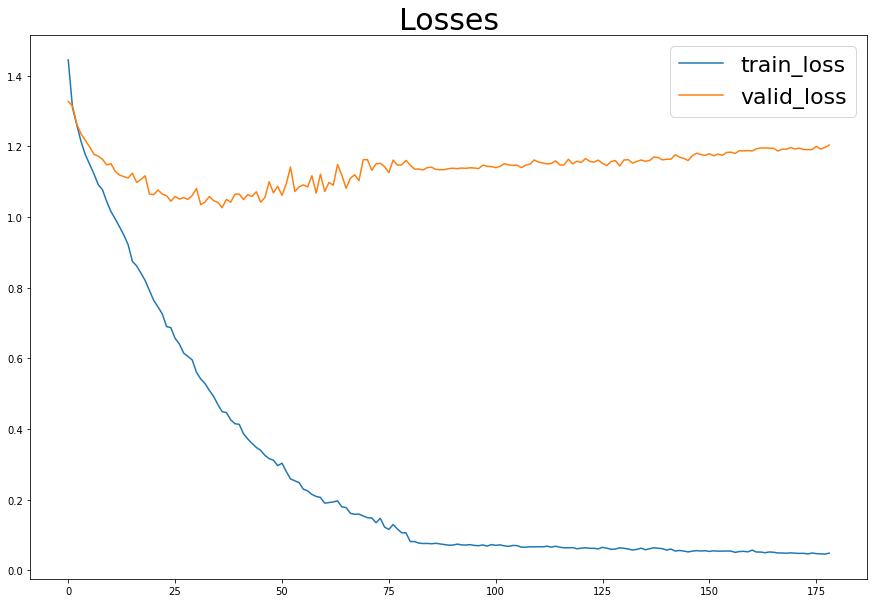

In [13]:
fig = plt.figure(figsize=(15,10))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Losses', fontsize=30)
plt.legend(['train_loss', 'valid_loss'], prop={'size': 22})
plt.show()

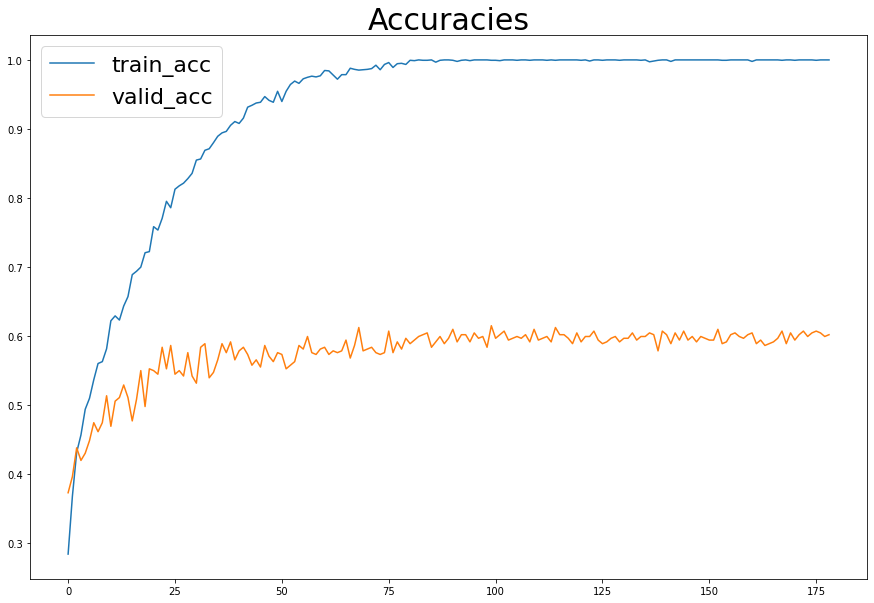

In [14]:
fig = plt.figure(figsize=(15,10))
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Accuracies', fontsize=30)
plt.legend(['train_acc', 'valid_acc'], prop={'size': 22})
plt.show()

In [15]:
# load in best model
best_model_path = bestModel
# define a new GCN
model = GCN()
# load state_dict
state_dict = torch.load(best_model_path)
# load the state dict into the new NN
model.load_state_dict(state_dict)
# send new NN to gpu
# turn on evaluation mode
model = model.cuda()
model.eval()
cudnn.benchmark = True

In [16]:
test_loss, test_acc = test(1, testloader)
print('test loss: {:.3f} | test acc: {:.3f}'.format(test_loss, test_acc*100))

test loss: 1.143 | test acc: 61.458
